<a href="https://colab.research.google.com/github/lukasbirki/Workshop-Classification/blob/main/Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  🤗 Demo Notebook 🤗
# <b><font color='#845554'>Multi-class</font></b> and  <b><font color='#FFC000'>Multi-label</font></b> Text Classification in Python

This notebook provides materials for the workshop **Multi-class and Multi-label Text Classification in Python** for the [Workshop for Ukraine Series](https://sites.google.com/view/dariia-mykhailyshyna/main/r-workshops-for-ukraine).

This notebook reuses materials kindly provided by the following sources with an open-source license:

**Multi-Class Classification**

- [🤗 Tasks: Text Classification](https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/sequence_classification.ipynb#scrollTo=D9jZx7Dvn1o_) (see also the [video-tutorial](https://www.youtube.com/watch?v=leNG9fN9FQU&ab_channel=HuggingFace))

**Multi-Label Classification**

- [Fine-tuning BERT (and friends) for multi-label text classification](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb)

If you  have any questions, [contact Lukas](https://www.gesis.org/institut/mitarbeitendenverzeichnis/person/Lukas.Birkenmaier) via Mai.


# Preparations

## Activate a GPU runtime

In order to run this notebook on a GPU, click on "Runtime" > "Change runtime type" > select "GPU" in the menue bar in to top left. Training a Transformer is much faster on a GPU. Given Google's usage limits for GPUs, it is advisable to first test your non-training code on a CPU (Hardware accelerator "None" instead of GPU) and only use the GPU once you know that everything is working.

## Install relevant packages

Unfortunately, the installation accelerate package requires the session to restart. Therefore, you need to first execute the following cell before you can run all code via "Runtime" -> "Run all".


In [ ]:
try:
    import accelerate
    print("accelerate is already installed")
except ImportError:
    !pip install accelerate -U
    quit() # You will be shown that the session has crashed, which is totally fine as Colab restarts the session
    print("Please run all code again (Runtime -> Run all!)")

accelerate is already installed


In [ ]:
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00


In [ ]:
## Load general packages
# some more specialised packages are loaded in each sub section
import pandas as pd
import numpy as np
from google.colab.data_table import DataTable
from datasets import load_metric


In [ ]:
# set random seed for reproducibility
SEED_GLOBAL = 12
np.random.seed(SEED_GLOBAL)

Even though we do not talk much about binary classification, is it actually the simplest case of multi-class classification with only two labels (e.g., positive/negative, yes/no, ...).

If you are interested in a simple use case of how to apply binary classification, you can checkout [this great tutorial](https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb)!


# <b><font color='#845554'>Multi-class Classification</font></b>






OK we start by loading our dataset, in our case the [AG News dataset](https://huggingface.co/datasets/ag_news), which is a collection of more than 1 million news articles. We only select a subset, as we want to limit the training to around 10 min.

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("ag_news")

# Randomly sample a subset of the data
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(10000))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(5000))

(10000, 2)
                                                text     label
0  Bangladesh paralysed by strikes Opposition act...     World
1  Desiring Stability Redskins coach Joe Gibbs ex...    Sports
2  Will Putin #39;s Power Play Make Russia Safer?...     World
3  U2 pitches for Apple New iTunes ads airing dur...  Sci/Tech
4  S African TV in beheading blunder Public broad...     World


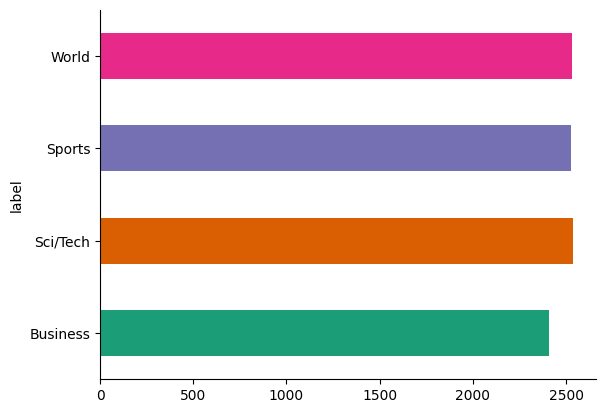

In [ ]:
# Distribution of sentiment in the dataset

from matplotlib import pyplot as plt
import seaborn as sns
df = pd.DataFrame(dataset['train'])

# Recoding into their labels
df['label'] = df['label'].replace({0: 'World', 1: 'Sports', 2: 'Business',3: "Sci/Tech"})

print(df.shape)
print(df.head())
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Prepare Data

In the lecture, we learned that Machine Learning models don't work with raw text. You need to convert text to numbers (token embeddings). During tokenization, our "tokenizer" transforms our input data:

- Adds special tokens to separate sentences and do classification
- Passes sequences of constant length (introduce padding)
- Creates array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). For our case, we will use [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert), a smaller, faster, cheaper, and lighter version of BERT. It works with TensorFlow and PyTorch!


In [ ]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

df_encoded = dataset.map(preprocess_function, batched=True)
df_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DataCollatorWithPadding is a class in Hugging Face Transformers that helps in preparing batches of data for training transformer models. Specifically, it is designed to handle cases where input sequences have different lengths by dynamically padding them within a batch.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Define Model

In [ ]:
import evaluate
import numpy as np

# Load the metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    # Specify the averaging method for multiclass, in our case "macro"
    f1_score = f1.compute(predictions=predictions, references=labels, average='macro')

    # Calculate and return all metrics
    return {
        'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
        'f1_macro': f1_score['f1']
    }


We also need to document the labels and their encodings

In [ ]:
id2label = {0: 'World', 1: 'Sports', 2: 'Business',3: "Sci/Tech"}
label2id = {"World": 0, "Sports": 1,"Business": 2,"Sci/Tech":3}

Now we can load the model and print out its architecture

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id)

# Printing all the layers of the model. If you look at the last layer (way down), you can see the linear layer with 11 output nodes (for each label).
# Please keep in mind that we did not yet apply a sigmoid activation function to each on of the nodes, this will be defined by the type of classification task.
for name, module in model.named_modules():
    print(name, module)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Train the model!

We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things:

* `TrainingArguments`, which specify training hyperparameters. All options can be found in the [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size (data chunks per step) to use for training/evaluation, how many epochs (full data cycles) to train for, and so on.
* a `Trainer` object, which manages the training process (docs can be found [here](https://huggingface.co/transformers/main_classes/trainer.html#id1)).

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df_encoded["train"],
    eval_dataset=df_encoded["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.338100,0.315943,0.907600,0.907654
2,0.237100,0.319794,0.915400,0.914800
3,0.147600,0.321701,0.923000,0.922712


TrainOutput(global_step=3750, training_loss=0.26444037170410156, metrics={'train_runtime': 143.3258, 'train_samples_per_second': 209.313, 'train_steps_per_second': 26.164, 'total_flos': 645654640274112.0, 'train_loss': 0.26444037170410156, 'epoch': 3.0})

## Evaluate

In [ ]:
trainer.evaluate()

{'eval_loss': 0.31594258546829224,
 'eval_accuracy': 0.9076,
 'eval_f1_macro': 0.9076541678683736,
 'eval_runtime': 5.481,
 'eval_samples_per_second': 912.248,
 'eval_steps_per_second': 114.031,
 'epoch': 3.0}

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Grab some text you'd like to run inference on:

In [ ]:
import torch

#This is a toy-sentence
text = "Firms are currently laying off people"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

#We load the best model from the trainer module and apply it to test sentence
trainer.model.eval()  # Ensuring that the model is in evaluation mode
logits = trainer.model(**encoding).logits

# Applying softmax to convert logits to probabilities
probabilities = torch.nn.functional.softmax(logits, dim=1)

# Getting the highest probability class
predicted_class = torch.argmax(probabilities, dim=1).item()

# Maping the predicted class index to the actual class label using id2label
predicted_label = id2label[predicted_class]

# Printing the result
print(f"Predicted class index: {predicted_class}")
print(f"Predicted class label: {predicted_label}")

# Also printing the probabilities for each class
probabilities_list = probabilities.tolist()[0]  # convert the tensor to a list
for idx, prob in enumerate(probabilities_list):
    print(f"{id2label[idx]}: {prob:.2f}")


Predicted class index: 2
Predicted class label: Business
World: 0.01
Sports: 0.00
Business: 0.94
Sci/Tech: 0.05
